In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image
from tensorflow.keras import applications
from tensorflow.keras import optimizers

### Data contains 1200 images (600 normal, 600 pneumonia). 800 will be used for train, 200 for validation, 200 for test

In [2]:
train_dir = r'D:\Diss\Train'
test_dir = r'D:\Diss\Test'
validation_dir = r'D:\Diss\Validation'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(256,256),
                                                   batch_size=20,
                                                   class_mode="binary")

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(256,256),
                                                       batch_size=20,
                                                       class_mode="binary")




Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
def showImage(image):
    image = image*255
    image = np.array(image, dtype=np.uint8)
    print(image)
    if np.ndim(image)>3:
        image = image[0]
    image = PIL.Image.fromarray(image)
    t.show()

In [6]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8,8,256)))
    
    model.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),padding="same",
                                    use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",
                                    use_bias=False, activation="tanh"))
    return model

In [7]:
g_test = generator()
g_test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0

### Check if model has been made

In [8]:
vgg = tf.keras.models.load_model("D:\Diss\Weights\VGG\Balanced\vgg")

OSError: SavedModel file does not exist at: D:\Diss\Weights\VGG\Balancedgg\{saved_model.pbtxt|saved_model.pb}

### Make if not

In [9]:
model = tf.keras.applications.VGG19(input_shape = (256,256,3),include_top=False,weights=None)
vgg = tf.keras.models.Sequential()
vgg.add(model)
vgg.add(layers.Flatten())
vgg.add(layers.Dense(512,activation="relu"))
vgg.add(layers.Dense(1,activation="sigmoid"))
vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 36,802,625
Trainable params: 36,802,625
Non-trainable params: 0
_________________________________________________________________


In [10]:
vgg.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
history = vgg.fit(train_generator,
                   steps_per_epoch=40,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[early_stop])

Epoch 1/30
40/40 [==============================] - 41s 755ms/step - loss: 0.6940 - binary_accuracy: 0.5863 - val_loss: 0.6927 - val_binary_accuracy: 0.5000
Epoch 2/30
40/40 [==============================] - 15s 368ms/step - loss: 0.6897 - binary_accuracy: 0.5387 - val_loss: 0.6720 - val_binary_accuracy: 0.5450
Epoch 3/30
40/40 [==============================] - 15s 359ms/step - loss: 0.4182 - binary_accuracy: 0.8338 - val_loss: 0.2802 - val_binary_accuracy: 0.8850
Epoch 4/30
40/40 [==============================] - 15s 359ms/step - loss: 0.1945 - binary_accuracy: 0.9212 - val_loss: 0.2515 - val_binary_accuracy: 0.8850
Epoch 5/30
40/40 [==============================] - 15s 359ms/step - loss: 0.1407 - binary_accuracy: 0.9488 - val_loss: 0.2045 - val_binary_accuracy: 0.9350
Epoch 6/30
40/40 [==============================] - 15s 365ms/step - loss: 0.1852 - binary_accuracy: 0.9250 - val_loss: 0.2201 - val_binary_accuracy: 0.9200
Epoch 7/30
40/40 [==============================] - 15s 37

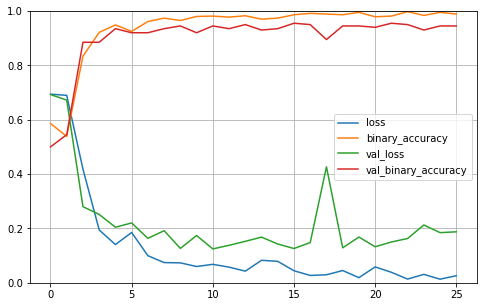

In [12]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [13]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                 target_size=(256,256),
                                                 class_mode="binary")

Found 200 images belonging to 2 classes.


In [14]:
def evaluate(model):
    test_loss, test_acc = model.evaluate(test_generator)
    train_loss, train_acc = model.evaluate(train_generator)
    
    print("Test loss: {0}, Test acc: {1} \nTrain loss: {2}, Train acc: {3}".format(test_loss,test_acc,
                                                                                   train_loss, train_acc))

In [15]:
evaluate(vgg)

40/40 [==============================] - 12s 270ms/step - loss: 0.0472 - binary_accuracy: 0.98758s - loss
Test loss: 0.3819844722747803, Test acc: 0.875 
Train loss: 0.047201741486787796, Train acc: 0.987500011920929


In [17]:
vgg.save(r'D:\Diss\Weights\VGG\Balanced\vgg')

INFO:tensorflow:Assets written to: D:\Diss\Weights\VGG\Balanced\vgg\assets


### Check for model

In [ ]:
res = tf.keras.models.load_model(r'D:\Diss\Weights\RES\Balanced\res')

In [18]:
model = tf.keras.applications.ResNet50V2(input_shape = (256,256,3),include_top=False,weights=None)
res = tf.keras.models.Sequential()
res.add(model)
res.add(layers.Flatten())
res.add(layers.Dense(512,activation="relu"))
res.add(layers.Dense(1,activation="sigmoid"))
res.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 90,674,689
Trainable params: 90,629,249
Non-trainable params: 45,440
_________________________________________________________________


In [19]:
res.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

In [23]:
res_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=False)
historyres = res.fit(train_generator,
                   steps_per_epoch=40,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[res_early_stop])

Epoch 1/30
40/40 [==============================] - 14s 342ms/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 3.9487 - val_binary_accuracy: 0.5000
Epoch 2/30
40/40 [==============================] - 14s 352ms/step - loss: 5.0889e-04 - binary_accuracy: 1.0000 - val_loss: 3.8798 - val_binary_accuracy: 0.5000
Epoch 3/30
40/40 [==============================] - 14s 341ms/step - loss: 3.7013e-04 - binary_accuracy: 1.0000 - val_loss: 3.6683 - val_binary_accuracy: 0.5000
Epoch 4/30
40/40 [==============================] - 14s 348ms/step - loss: 4.5071e-04 - binary_accuracy: 1.0000 - val_loss: 3.5897 - val_binary_accuracy: 0.5000
Epoch 5/30
40/40 [==============================] - 14s 340ms/step - loss: 2.9457e-04 - binary_accuracy: 1.0000 - val_loss: 3.3717 - val_binary_accuracy: 0.5000
Epoch 6/30
40/40 [==============================] - 14s 345ms/step - loss: 2.5474e-04 - binary_accuracy: 1.0000 - val_loss: 2.9999 - val_binary_accuracy: 0.5000
Epoch 7/30
40/40 [====================

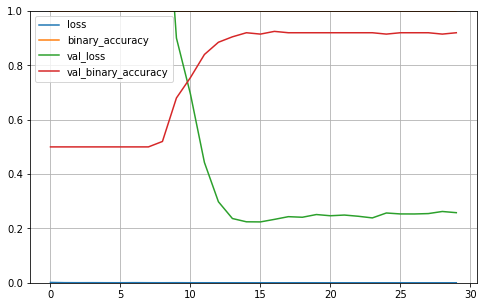

In [24]:
pd.DataFrame(historyres.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [25]:
evaluate(res)

40/40 [==============================] - 11s 257ms/step - loss: 2.9137e-05 - binary_accuracy: 1.0000
Test loss: 0.608567476272583, Test acc: 0.8299999833106995 
Train loss: 2.9137136152712628e-05, Train acc: 1.0


In [26]:
res.save(r'D:\Diss\Weights\RES\Balanced\res')

INFO:tensorflow:Assets written to: D:\Diss\Weights\RES\Balanced\res\assets


C:\Users\Pete\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
Inc = tf.keras.models.load_model(r'D:\Diss\Weights\INC\Balanced\inc')

In [27]:
model = tf.keras.applications.InceptionV3(input_shape = (256,256,3),include_top=False,weights=None)
Inc = tf.keras.models.Sequential()
Inc.add(model)
Inc.add(layers.Flatten())
Inc.add(layers.Dense(512,activation="relu"))
Inc.add(layers.Dense(1,activation="sigmoid"))
Inc.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 59,552,545
Trainable params: 59,518,113
Non-trainable params: 34,432
_________________________________________________________________


In [28]:
Inc.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(learning_rate=2e-5),
             metrics=keras.metrics.BinaryAccuracy())

In [29]:
historyInc = Inc.fit(train_generator,
                   steps_per_epoch=40,
                   epochs=30,
                   validation_data=validation_generator,
                   validation_steps=10,
                    callbacks=[early_stop])

Epoch 1/30
40/40 [==============================] - 23s 376ms/step - loss: 0.5811 - binary_accuracy: 0.7688 - val_loss: 0.7593 - val_binary_accuracy: 0.5000
Epoch 2/30
40/40 [==============================] - 14s 340ms/step - loss: 0.2793 - binary_accuracy: 0.9000 - val_loss: 1.0986 - val_binary_accuracy: 0.5000
Epoch 3/30
40/40 [==============================] - 14s 352ms/step - loss: 0.1964 - binary_accuracy: 0.9250 - val_loss: 1.3970 - val_binary_accuracy: 0.5000
Epoch 4/30
40/40 [==============================] - 14s 339ms/step - loss: 0.2010 - binary_accuracy: 0.9225 - val_loss: 2.2507 - val_binary_accuracy: 0.5000
Epoch 5/30
40/40 [==============================] - 14s 342ms/step - loss: 0.1508 - binary_accuracy: 0.9450 - val_loss: 2.8536 - val_binary_accuracy: 0.5000
Epoch 6/30
40/40 [==============================] - 14s 339ms/step - loss: 0.1045 - binary_accuracy: 0.9600 - val_loss: 3.1706 - val_binary_accuracy: 0.5000
Epoch 7/30
40/40 [==============================] - 14s 35

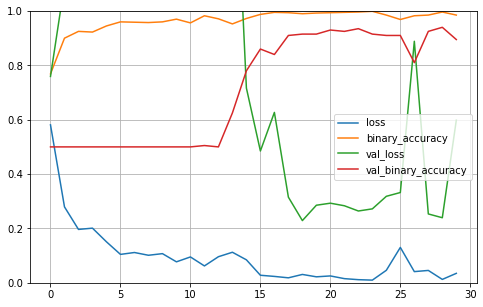

In [30]:
pd.DataFrame(historyInc.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show() 

In [31]:
evaluate(Inc)

40/40 [==============================] - 11s 250ms/step - loss: 0.1801 - binary_accuracy: 0.9737
Test loss: 1.5670291185379028, Test acc: 0.7599999904632568 
Train loss: 0.1801101267337799, Train acc: 0.9737499952316284


In [32]:
Inc.save(r'D:\Diss\Weights\INC\Balanced\inc')

INFO:tensorflow:Assets written to: D:\Diss\Weights\INC\Balanced\inc\assets
